In [29]:
#!pip install openpyxl

In [30]:
import pandas as pd
pd.options.mode.chained_assignment = None

df_gdp = pd.read_excel('data/mpd2023_provisional.xlsx', sheet_name='GDPpc')
df_regions = df_gdp[:2]
df_regions = df_regions.T
df_regions = df_regions[1:]
df_regions = df_regions.reset_index()

df_regions.columns = ['country_name', 'region', 'iso_a3']

df_gfp_values = df_gdp[2:]
df_gfp_values = df_gfp_values[~df_gfp_values['GDP pc 2011 prices'].isna()]
df_gfp_values = df_gfp_values.set_index('GDP pc 2011 prices')
df_gfp_values = df_gfp_values.unstack().reset_index()
df_gfp_values.columns = ['country_name', 'year', 'gdp_pc']
df_gfp_values = df_gfp_values.dropna()
df_gfp_values = df_gfp_values[df_gfp_values['year']<=1900]

df_gfp_values = pd.merge(df_gfp_values, df_regions, on = 'country_name')
df_gfp_values = df_gfp_values.reset_index(drop=True)
df_gfp_values = df_gfp_values.drop(columns=['region'])

len(set(df_gfp_values['country_name']))

77

In [52]:
df_gfp_values[['country_name', 'iso_a3']].drop_duplicates().reset_index(drop=True).to_csv('results/iso.csv')

In [31]:
df_gfp_values[df_gfp_values['country_name']=='Japan']

,country_name,year,gdp_pc,iso_a3
3379,Japan,730,597.84,JPN
3380,Japan,1000,1009.65,JPN
3381,Japan,1120,926.97,JPN
3382,Japan,1280,841.11,JPN
3383,Japan,1450,866.55,JPN
3384,Japan,1600,1061,JPN
3385,Japan,1700,1073,JPN
3386,Japan,1721,1073.25,JPN
3387,Japan,1750,953,JPN
3388,Japan,1800,1317,JPN


In [32]:
list(set(df_gfp_values[(df_gfp_values['year']>=1800) & (df_gfp_values['year']<=1880)].country_name))

['Syrian Arab Republic',
 'India',
 'Ireland',
 'Netherlands',
 'Canada',
 'Cuba',
 'Argentina',
 'Czechoslovakia',
 'Spain',
 'Republic of Korea',
 'D.P.R. of Korea',
 'Romania',
 'Former Yugoslavia',
 'Iran (Islamic Republic of)',
 'Viet Nam',
 'Colombia',
 'Denmark',
 'Jordan',
 'United States',
 'Nepal',
 'Uruguay',
 'Greece',
 'Lebanon',
 'Sweden',
 'Sri Lanka',
 'Albania',
 'Bolivia (Plurinational State of)',
 'Algeria',
 'Indonesia',
 'Australia',
 'Italy',
 'Bulgaria',
 'Japan',
 'Morocco',
 'Philippines',
 'Brazil',
 'China',
 'Portugal',
 'Thailand',
 'Iraq',
 'Poland',
 'State of Palestine',
 'Chile',
 'France',
 'Malaysia',
 'Germany',
 'Hungary',
 'Austria',
 'Belgium',
 'China, Hong Kong SAR',
 'Finland',
 'Ecuador',
 'Liberia',
 'Egypt',
 'Saudi Arabia',
 'Jamaica',
 'Myanmar',
 'Norway',
 'Taiwan, Province of China',
 'Estonia',
 'South Africa',
 'Singapore',
 'United Kingdom',
 'Tunisia',
 'Turkey',
 'Mexico',
 'New Zealand',
 'Russian Federation',
 'Former USSR',
 'Ic

### Display country GDP per capita

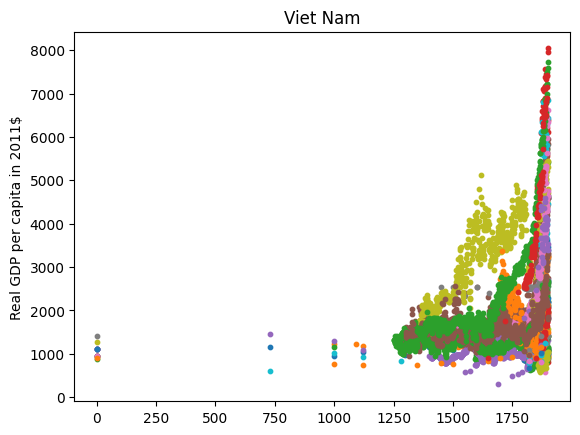

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import os

show = False

# Create the directory if it doesn't exist
directory = "gdp_pc_country_fig"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Assuming your DataFrame is named df_gdp
# Group the DataFrame by country_name
grouped = df_gfp_values.groupby('country_name')

# Plot GDP per capita over time for each country
for name, group in grouped:
    plt.scatter(group['year'], group['gdp_pc'], s=10)
    plt.title(name)
    plt.ylabel('Real GDP per capita in 2011$')
    plt.savefig(os.path.join(directory, f'{name}.png'))
    # Show plot
    if show:
        plt.show()

### Load Population

In [55]:
df_population = pd.read_excel('data/mpd2023_provisional.xlsx', sheet_name='Population')
df_population = df_population[2:]
df_population = df_population[~df_population['Population'].isna()]
df_population = df_population.set_index('Population')
df_population = df_population.unstack().reset_index()
df_population.columns = ['country_name', 'year', 'pop']
df_population = df_population[df_population['year']<=1900]

len(set(df_population['country_name']))

169

### Interpolate Population

In [35]:
import itertools

all_years = range(1, 1901)
all_countries = df_population['country_name'].unique()
df_regions_years = pd.DataFrame(list(itertools.product(all_countries, all_years)), columns=['country_name', 'year'])

df_population_all = pd.merge(df_population, df_regions_years, on = ['country_name', 'year'], how = 'outer')
df_population_all = df_population_all.sort_values(by=['country_name', 'year'])

# Bfore 1800, interloate linearly, after 1800, interpolate exponentially
#linear_interpolated = df_population_all[df_population_all['year'] <= 1800]
linear_interpolated = df_population_all.copy()

### Linear Interpolation Before 1800

In [36]:
df_int = []
for country in linear_interpolated['country_name'].unique():
    res= linear_interpolated[linear_interpolated['country_name']==country]
    res['pop'] = pd.to_numeric(res['pop'], errors='coerce')
    res['pop'] = res['pop'].interpolate(how = 'linear')
    df_int.append(res)

linear_interpolated_final = pd.concat([x for x in df_int])
linear_interpolated_final = linear_interpolated_final.dropna().reset_index(drop=True)

In [37]:
test = linear_interpolated_final.copy()
test = test[test['country_name']=='China']
test[test['year']==1100]

,country_name,year,pop
15705,China,1100,67800.0


### Quadratic interpolation after 1800

In [38]:
# exponential_interpolated = df_population_all[df_population_all['year'] >= 1800]

# df_int = []
# for country in exponential_interpolated['country_name'].unique():
#     res= exponential_interpolated[exponential_interpolated['country_name']==country]
#     res['pop'] = pd.to_numeric(res['pop'], errors='coerce')
#     res['pop'] = res['pop'].interpolate(how = 'quadratic')
#     df_int.append(res)

# expo_interpolated_final = pd.concat([x for x in df_int])
# expo_interpolated_final = expo_interpolated_final.dropna().reset_index(drop=True)

### Concat the two datasets

In [39]:
df_population_interpolated = linear_interpolated_final.copy()
# df_population_interpolated = pd.concat([linear_interpolated_final, expo_interpolated_final])
df_population_interpolated = df_population_interpolated.dropna()
df_population_interpolated.to_csv('results/population_interpolated.csv')

### Merge population and GDP per capita

In [40]:
df_gdp_population = pd.merge(df_population_interpolated, df_gfp_values, on = ['country_name', 'year'], how = 'right')

### Regions Analysis

In [41]:
# load regions and equivalent country_name
df_regions_culture = pd.read_csv('../environnement_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()
list(set(df_regions_culture.region))
df_regions_culture[df_regions_culture['region']=='Chinese world']

,region,iso_a3
44,Chinese world,MNG
45,Chinese world,TWN
46,Chinese world,CHN


In [42]:
keep_regions_list = ['Italy',
 'Portugal', #OK
 'Low countries', # Weighted Average of Belgium and Netherlands normalized by population
 'Nordic countries', # Average of Norway, Sweden, Denmark and Iceland normalized by population
 'Indian world',
 'Chinese world',
 'Korea',
 'Arabic world',
 'Greek World',
 'Eastern Europe',
 'France',
 'Persian world',
 'Japan',
 'Latin World',
 'Spain',
 'United Kingdom',
 'Balkans',
 'German world']

In [43]:
df_gdp_pop_regions = pd.merge(df_gdp_population, df_regions_culture, on = ['iso_a3'])
df_gdp_pop_regions = df_gdp_pop_regions[df_gdp_pop_regions['region'].isin(keep_regions_list)]

df_gdp_weighted = df_gdp_pop_regions.groupby(['region', 'year']).apply(lambda x: (x['gdp_pc'] * x['pop']).sum() / x['pop'].sum())
df_gdp_weighted = df_gdp_weighted.reset_index()
df_gdp_weighted = df_gdp_weighted.rename(columns={0: 'gdp_pc_weighted'})

df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>1]


# Step 1: Round the 'year' column to the nearest multiple of 50
df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>=1000]
df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']<=1880]

#df_gdp_weighted['decade'] = (df_gdp_weighted['year'] // 50) * 50

df_gdp_weighted['decade'] = df_gdp_weighted['year'].apply(lambda x: round(x / 50) * 50)
df_gdp_weighted = df_gdp_weighted.groupby(['region', 'decade'])['gdp_pc_weighted'].mean().reset_index()

df_gdp_pop_regions['decade'] = df_gdp_pop_regions['year'].apply(lambda x: round(x / 50) * 50)
df_gdp_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade'])['pop'].mean().reset_index()

# Add population

df_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade']).apply(lambda x: x['pop'].sum()).reset_index()
df_pop_regions = df_pop_regions.rename(columns={0: 'pop'})


# Weighted GDP and population
df_gdp_weighted_pop = pd.merge(df_gdp_weighted, df_pop_regions, on = ['region', 'decade'])
df_gdp_weighted_pop.to_csv('results/gdp_weighted_pop_fifty.csv', index=False)

### Every 10 years

In [44]:
df_gdp_pop_regions = pd.merge(df_gdp_population, df_regions_culture, on = ['iso_a3'])
df_gdp_pop_regions = df_gdp_pop_regions[df_gdp_pop_regions['region'].isin(keep_regions_list)]

df_gdp_weighted = df_gdp_pop_regions.groupby(['region', 'year']).apply(lambda x: (x['gdp_pc'] * x['pop']).sum() / x['pop'].sum())
df_gdp_weighted = df_gdp_weighted.reset_index()
df_gdp_weighted = df_gdp_weighted.rename(columns={0: 'gdp_pc_weighted'})

df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>1]


# Step 1: Round the 'year' column to the nearest multiple of 50
df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']>=1000]
df_gdp_weighted = df_gdp_weighted[df_gdp_weighted['year']<=1880]

#df_gdp_weighted['decade'] = (df_gdp_weighted['year'] // 50) * 50

df_gdp_weighted['decade'] = df_gdp_weighted['year'].apply(lambda x: round(x / 10) * 10)
df_gdp_weighted = df_gdp_weighted.groupby(['region', 'decade'])['gdp_pc_weighted'].mean().reset_index()


df_gdp_pop_regions['decade'] = df_gdp_pop_regions['year'].apply(lambda x: round(x / 10) * 10)
df_gdp_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade'])['pop'].mean().reset_index()

# Add population

df_pop_regions = df_gdp_pop_regions.groupby(['region', 'decade']).apply(lambda x: x['pop'].sum()).reset_index()
df_pop_regions = df_pop_regions.rename(columns={0: 'pop'})


# Weighted GDP and population
df_gdp_weighted_pop = pd.merge(df_gdp_weighted, df_pop_regions, on = ['region', 'decade'])
df_gdp_weighted_pop.to_csv('results/gdp_weighted_pop_decade.csv', index=False)

## Display

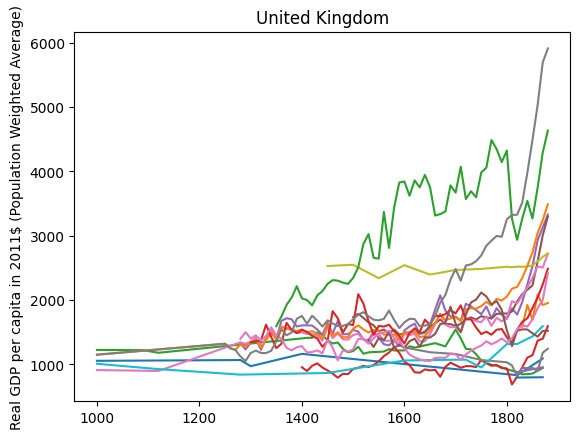

In [45]:
show = True

# Create the directory if it doesn't exist
directory = "gdp_pc_region_fig"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Assuming your DataFrame is named df_gdp
# Group the DataFrame by country_name
grouped = df_gdp_weighted.groupby('region')

# Plot GDP per capita over time for each country
for name, group in grouped:
    #plt.scatter(group['decade'], group['gdp_pc_weighted'], s=10)
    plt.plot(group['decade'], group['gdp_pc_weighted'])
    plt.title(name)
    plt.ylabel('Real GDP per capita in 2011$ (Population Weighted Average)')
    plt.savefig(os.path.join(directory, f'{name}.png'))


<!-- ### Load Culture -->

In [46]:
# df_culture = pd.read_csv('../unseen_species_model/results/occupation/unseen_data_occupation.csv', index_col=[0])
# df_culture = df_culture.drop(columns=['occupation', 'model_type'])
# df_culture = df_culture.groupby(['region_name', 'decade']).sum().reset_index()

### Reading

In [47]:
import pandas as pd
df = pd.read_csv('results/gdp_weighted_pop_decade.csv')
df = df[df['decade']>=1800]
list(set(df.region))

['Korea',
 'France',
 'Greek World',
 'Latin World',
 'Nordic countries',
 'Balkans',
 'Portugal',
 'United Kingdom',
 'Low countries',
 'German world',
 'Arabic world',
 'Chinese world',
 'Japan',
 'Eastern Europe',
 'Italy',
 'Persian world',
 'Spain',
 'Indian world']